In [3]:
from __future__ import print_function
import sys
sys.path.append('../build/')
%pylab inline
np.set_printoptions(precision=4, suppress=True)
import versor as vsr
import pandas as pd
from versor.drawing import *
from motor_estimation import MotorEstimationSolver
from game import VDMotorEstimationSolver

Populating the interactive namespace from numpy and matplotlib


/Users/lars/anaconda3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['Inf']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Generate motors

In [15]:
n_motors = 1000
motors = [((vsr.Vec(*np.random.random(3)).unit() * np.random.uniform(-0.5,0.5)).trs() * 
           vsr.Rot(vsr.Biv(*np.random.random(3)).unit() * np.random.uniform(-pi, pi) * -0.5)) for i in range(n_motors)]

In [3]:
n_motors = 1000
motors = [((vsr.Vec(*np.random.random(3)).unit() * np.random.uniform(-1000,1000)).trs() * 
           vsr.Rot(vsr.Biv(*np.random.random(3)).unit() * (pi))) for i in range(n_motors)]

# Estimate motors from point observations

In [16]:
n_points=30
points_a = [vsr.Vec(*np.random.uniform(-100,100,3)).null() for i in range(n_points)]
points_b = [[point.spin(motor) for point in points_a] for motor in motors]

In [17]:
initial_motor = vsr.Mot(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
norms = []
for i in range(n_motors):
    mes = MotorEstimationSolver(initial_motor)
    for a, b in zip(points_a, points_b[i]):
        mes.add_point_correspondences_residual_block(a,b)
#     mes.set_parameterization('POLAR_DECOMPOSITION_TANGENT')
    mes.set_parameterization('CAYLEY')
#     mes.set_parameterization('BIVECTOR_GENERATOR')

    mes.linear_solver_type = 'DENSE_QR'
    (estimated_motor, summary, _) = mes.solve()
    norm = np.linalg.norm(motors[i].rev() * estimated_motor)
#     if norm > 1.0001:
#     print(norm)
#         print(summary['brief_report'])
    norms.append(norm)
print(np.sum(norms)/n_motors)

1.0


# Estimate motors from point observations

In [18]:
n_lines = 10

In [19]:
lines_a = [vsr.Dll(vsr.Vec(*np.random.random(3)).null(), 
                   vsr.Vec(*np.random.random(3)).unit()).unit() for i in range(n_lines)]

In [20]:
lines_b = [[line.spin(motor) for line in lines_a] for motor in motors]

In [32]:
# initial_motor = vsr.Mot(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
initial_motor = vsr.Vec(1,1,1).trs() * vsr.Rot(vsr.Biv(1,2,3).unit() * 0.01)
norms = []
wrong_motors = []
for i in range(n_motors):
    mes = MotorEstimationSolver(initial_motor)
#     for a, b in zip(points_a, points_b[i]):
#         mes.add_point_correspondences_residual_block(a,b)
    for a, b in zip(lines_a, lines_b[i]):
#         mes.add_line_commutator_residual_block(a,b)
#         mes.add_line_correspondences_residual_block(a,b)
        mes.add_line_angle_distance_residual_block(a,b)
    mes.set_parameterization('BIVECTOR_GENERATOR')
    mes.linear_solver_type = 'DENSE_QR'
    mes.max_num_iterations = 50
#     mes.function_tolerance = 1e-3
    mes.parameter_tolerance = 1e-4
    (estimated_motor, summary, _) = mes.solve()
#     print(summary['brief_report'])
    norm = np.linalg.norm(motors[i].rev() * estimated_motor)
    if norm > 1.000001:
        wrong_motors.append((motors[i], estimated_motor))
#         print(i)
#         print(norm)
#         print(summary['brief_report'])
        norms.append(norm)
print(len(norms))

0


In [69]:
theta = pi/2
(1.0 - np.cos(theta))**2

0.99999999999999978

In [11]:
1e-5

1e-05

In [71]:
4 * np.sin(theta/2.0)**4

0.99999999999999967

In [72]:
f = lambda th : (1.0 - np.cos(th/2))**2

In [22]:
motor = ((vsr.Vec(100,200,300).unit()).trs() * 
          vsr.Rot(vsr.Biv(*np.random.random(3)).unit() * (np.pi/2)))
a = lines_a[0]
b = a.spin(motor)
X = ((b * a.inv()).log() * 0.5).exp()
t = X.trs()
if np.abs(1.0 - X[0]) > 0:
    w = t.reject_from(X.dll().biv().unit())
    cost = np.linalg.norm(np.array([w[0], w[1], w[2], 1.0 - X[0]]))
else:
    cost = np.linalg.norm(np.array([t[0], t[1], t[2], 1.0 - X[0]]))
print(cost)

0.675282224826


In [23]:
vsr.Dll(0,0,1,0,0,0) * vsr.Dll(0,0,1,0,0,0).spin(vsr.Vec(100,200,300).trs() * vsr.Rot(vsr.Biv(1,0,0).unit() * (pi)))

Mot: [ -1 2.4e-16 0 0 0 -2e+02 -3e+02 7.3e-14 ]

In [24]:
np.array([(2.0 * np.arctan2(wrong_motor[0].rot().biv().norm(), wrong_motor[0][0]),
 wrong_motor[0].trs().norm()) for wrong_motor in wrong_motors[:] ])

array([], dtype=float64)

In [33]:
print(summary['full_report'])


Solver Summary (v 1.12.0-eigen-(3.3.1)-lapack-suitesparse-(4.5.3)-cxsparse-(3.1.9)-no_openmp)

                                     Original                  Reduced
Parameter blocks                            1                        1
Parameters                                  8                        8
Effective parameters                        6                        6
Residual blocks                            10                       10
Residual                                   40                       40

Minimizer                        TRUST_REGION

Dense linear algebra library            EIGEN
Trust region strategy     LEVENBERG_MARQUARDT

                                        Given                     Used
Linear solver                        DENSE_QR                 DENSE_QR
Threads                                     1                        1
Linear solver threads                       1                        1
Linear solver ordering              AUTOMATIC        

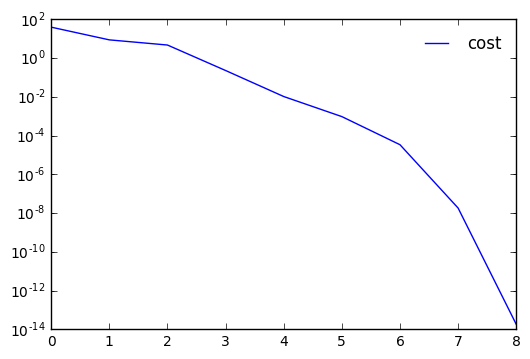

In [29]:
fig, ax = plt.subplots(1)
ax.plot(pd.DataFrame(summary['iterations'])['cost'])

ax.semilogy()
legend = ax.legend(frameon=False)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

In [13]:
def daniilidis_motor(LAs, LBs):
    Ds = []
    for LA, LB in zip(LAs, LBs):
        D = np.zeros((8,8))
        for i in range(8):
            ei = vsr.Mot(0,0,0,0,0,0,0,0)
            ei[i] = 1.0
            D[:,i] = np.array(ei * LA - LB * ei)
        Ds.append(D[1:7,:].copy())
    
    Ds = np.array(Ds).reshape(-1,8)
    [U, s, Vt] = np.linalg.svd(Ds)

    v7 = Vt.T[:,-2].copy()
    v8 = Vt.T[:,-1].copy()
    
    v7 = np.array([v7[0], v7[3], -v7[2], v7[1], -v7[7],v7[4], v7[5], v7[6]])
    v8 = np.array([v8[0], v8[3], -v8[2], v8[1], -v8[7],v8[4], v8[5], v8[6]])
    
    u1 = v7[:4]
    v1 = v7[4:]
    u2 = v8[:4]
    v2 = v8[4:]

    a = np.inner(u1,v1)
    b = np.inner(u1,v2) + np.inner(u2,v1)
    c = np.inner(u2,v2)
    [s1, s2] = np.roots([a,b,c])

    val1 = (s1**2 * np.inner(u1,u1)) + (2 * s1 * np.inner(u1,u2)) + (np.inner(u2,u2))
    val2 = (s2**2 * np.inner(u1,u1)) + (2 * s2 * np.inner(u1,u2)) + (np.inner(u2,u2))
    
    if val1 > val2:
        s = s1
        val = val1
    else:
        s = s2
        val = val2

    lambda2 = np.sqrt(1./val)
    lambda1 = s * lambda2
    
    m_arr = lambda1 * Vt.T[:,-2] + lambda2 * Vt.T[:,-1]

    return vsr.Mot(*m_arr)

In [14]:
wrong_motors = []
norms = []
for i in range(n_motors):
    estimated_motor = daniilidis_motor(lines_a, lines_b[i])
    norm = np.abs(np.linalg.norm(motors[i].rev() * estimated_motor))
    if norm > 1.000001:
        wrong_motors.append((motors[i], estimated_motor, norm))
        norms.append(norm)
print(len(norms))

0


In [80]:
wrong_motors = []
norms = []
for i in range(n_motors):
    vd = VDMotorEstimationSolver()
    vd.add_dual_line_observations(lines_a,lines_b[i])
    estimated_motor = vd.solve()
    print(estimated_motor.rot())
    print(motors[i].rot())
    norm = np.abs(np.linalg.norm(motors[i].rev() * estimated_motor))
    if norm > 1.000001:
        wrong_motors.append((motors[i].rot(), estimated_motor.rot(), norm))
        norms.append(norm)
print(len(norms))


Rot: [ 0.78 0.12 0.41 0.45 ]
Rot: [ 0.78 0.12 0.41 0.45 ]
Rot: [ 0.53 0.23 0.8 0.17 ]
Rot: [ 0.53 0.23 0.8 0.17 ]
Rot: [ -0.8 0.43 0.41 0.076 ]
Rot: [ 0.8 -0.43 -0.41 -0.076 ]
Rot: [ -0.31 -0.49 -0.21 -0.79 ]
Rot: [ 0.31 0.49 0.21 0.79 ]
Rot: [ 0.75 0.59 0.28 0.073 ]
Rot: [ 0.75 0.59 0.28 0.073 ]
Rot: [ 0.92 0.14 0.27 0.24 ]
Rot: [ 0.92 0.14 0.27 0.24 ]
Rot: [ 0.69 0.43 0.26 0.51 ]
Rot: [ 0.69 0.43 0.26 0.51 ]
Rot: [ 0.25 -0.75 -0.5 -0.35 ]
Rot: [ 0.25 -0.75 -0.5 -0.35 ]
Rot: [ 0.76 -0.36 -0.42 -0.34 ]
Rot: [ 0.76 -0.36 -0.42 -0.34 ]
Rot: [ -0.89 -0.32 -0.012 -0.32 ]
Rot: [ 0.89 0.32 0.012 0.32 ]
Rot: [ 1 0.0094 0.027 0.00012 ]
Rot: [ 1 0.0094 0.027 0.00012 ]
Rot: [ -0.43 -0.065 -0.5 -0.75 ]
Rot: [ 0.43 0.065 0.5 0.75 ]
Rot: [ -0.25 0.68 0.64 0.25 ]
Rot: [ 0.25 -0.68 -0.64 -0.25 ]
Rot: [ -0.8 0.01 0.4 0.46 ]
Rot: [ 0.8 -0.01 -0.4 -0.46 ]
Rot: [ 0.13 0.57 0.61 0.54 ]
Rot: [ 0.13 0.57 0.61 0.54 ]
Rot: [ 0.99 0.068 0.098 0.093 ]
Rot: [ 0.99 0.068 0.098 0.093 ]
Rot: [ 0.29 0.14 0.87 0.38 ]

In [81]:
np.array([(2.0 * np.arctan2(wrong_motor[0].rot().biv().norm(), wrong_motor[0][0]),
 wrong_motor[0].trs().norm(), wrong_motor[2]) for wrong_motor in wrong_motors[:] ])

AttributeError: 'versor_pybind11.Rot' object has no attribute 'rot'

In [82]:
norms

[4187.3623971635234,
 2740.2891104819932,
 495.04435500980668,
 38.554145995273437,
 3331.2094213824835,
 4865.2203719947038,
 3900.7000911726514,
 2930.5244964994586,
 506.20789163222469,
 139.1103800001203,
 1513.4692151209886,
 454.65550052724797,
 4034.2942765780158,
 3825.2908249839188,
 2967.2875938768284,
 4451.0716574633479,
 3255.0114042014798,
 1277.4184774493215,
 514.04374403038889,
 997.77710659306956,
 1467.7425662462047,
 3637.0808726377377,
 330.22674620728674,
 2976.0067562321847,
 2463.888830724235,
 4177.2854818204733,
 1837.3517302955993,
 147.63589604254716,
 3482.1567615993931,
 960.90994308428253,
 2876.9808553715866,
 3242.0338226949734,
 3891.7984887125081,
 2958.7680939053648,
 3769.2771143416267,
 3677.0184338024433,
 1142.2076450377401,
 1824.3320240565554,
 2474.273733829019,
 3805.8828704732227,
 2546.3439808923404,
 3343.1764327852979,
 4341.4158883344708,
 785.12440690473386,
 4595.4112481607499,
 4669.4262767907549,
 2804.0437435106251,
 1667.2006122178

In [83]:
def gauss_newton(lines_a, lines_b, initial_motor=vsr.Mot(1,0,0,0,0,0,0,0), max_iterations=10):
    Jci = lambda ei, M, l1, l2 : np.array((ei.comm(l1.spin(M))).comm(l2)) * 2
    fci = lambda M, l1, l2 : np.array(l1.spin(M).comm(l2)).reshape(6,1)
    M = initial_motor
    eps1 = 1e-6
    eps2 = 1e-6
    rsc = []
    for i in range(max_iterations):
        k = len(rsc)
        Jc = np.array([np.array([Jci(ei, M, a, b) for ei in [vsr.Dll(1,0,0,0,0,0), 
                                                             vsr.Dll(0,1,0,0,0,0),
                                                             vsr.Dll(0,0,1,0,0,0),
                                                             vsr.Dll(0,0,0,1,0,0),
                                                             vsr.Dll(0,0,0,0,1,0),
                                                             vsr.Dll(0,0,0,0,0,1)]]).reshape(6,6).T 
                    for a, b in zip(lines_a, lines_b) ]).reshape(-1,6)
    #     print(Jc)
        fc = np.array([fci(M,a,b) for a, b in zip(lines_a, lines_b)]).reshape(-1,1)
        A = np.dot(Jc.T,Jc)
        g = np.dot(Jc.T, fc)
        r = np.dot(fc.T,fc)[0][0] / 2
        rsc.append(r)
        if r < 1e-6:
            break
        h = np.dot(np.linalg.pinv(A), -g)
    #     h = -g
        B = vsr.Dll(*h)
        M = B.exp() * M
    return M

# Planes

In [90]:
n_planes = 10
planes_a = []
for i in range(10):
    dir_vec = vsr.Vec(*np.random.random(3)).unit()
    distance = np.random.uniform(-1000,1000)
    planes_a.append(vsr.Dlp(dir_vec,distance))
planes_b = [[plane.spin(motor) for plane in planes_a] for motor in motors]

In [91]:
len(planes_b)

1000

In [106]:
initial_motor = vsr.Mot(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
norms = []
wrong_motors = []
for i in range(n_motors):
    mes = MotorEstimationSolver(initial_motor)
    for a, b in zip(planes_a, planes_b[i]):
#         mes.add_dual_plane_commutator_residual_block(a,b)
#         mes.add_dual_plane_angle_error_residual_block(a,b)
        mes.add_dual_plane_difference_residual_block(a,b)
    mes.set_parameterization('BIVECTOR_GENERATOR')
    mes.linear_solver_type = 'DENSE_QR'
    mes.max_num_iterations = 50
    mes.parameter_tolerance = 1e-7
    (estimated_motor, summary, _) = mes.solve()
    norm = np.linalg.norm(motors[i].rev() * estimated_motor)
    if norm > 1.000001:
        wrong_motors.append((motors[i], estimated_motor))
#         print(i)
#         print(norm)
#         print(summary['brief_report'])
        norms.append(norm)
print(len(norms))

0


In [107]:
np.array([(2.0 * np.arctan2(wrong_motor[0].rot().biv().norm(), wrong_motor[0][0]),
 wrong_motor[0].trs().norm()) for wrong_motor in wrong_motors[:] ])

array([], dtype=float64)

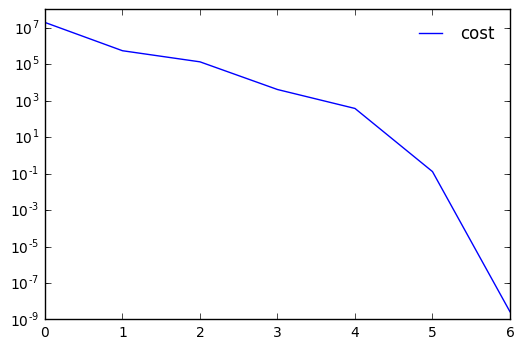

In [108]:
fig, ax = plt.subplots(1)
ax.plot(pd.DataFrame(summary['iterations'])['cost'])

ax.semilogy()
legend = ax.legend(frameon=False)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

In [109]:
print(summary['full_report'])


Solver Summary (v 1.12.0-eigen-(3.3.1)-lapack-suitesparse-(4.5.3)-cxsparse-(3.1.9)-no_openmp)

                                     Original                  Reduced
Parameter blocks                            1                        1
Parameters                                  8                        8
Effective parameters                        6                        6
Residual blocks                            10                       10
Residual                                   40                       40

Minimizer                        TRUST_REGION

Dense linear algebra library            EIGEN
Trust region strategy     LEVENBERG_MARQUARDT

                                        Given                     Used
Linear solver                        DENSE_QR                 DENSE_QR
Threads                                     1                        1
Linear solver threads                       1                        1
Linear solver ordering              AUTOMATIC        